In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [46]:
#Import shop data
def import_data() -> pd.DataFrame:
    """
    Import sales data from file for shop.
    :param shop: Integer of current shop name"
    :return: pd.DataFrame containing sales data for shop
    """
    df = pd.read_csv('data_prepared.csv')
    #convert date object column to datetime
    df['date_column'] =  pd.to_datetime(df['date_column'])
    #Set date column as index
    df = df.set_index('date_column')
    
    return df

df = import_data()
df.head()

,num_signups,num_signups_one_back,num_signups_twelve_back,year,month,province_eastern cape,province_free state,province_gauteng,province_kwazulu natal,province_limpopo,province_mpumalanga,province_north west,province_northern cape,province_western cape
date_column,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,2018,1,1,0,0,0,0,0,0,0,0
2018-02-01,1.0,0.0,0.0,2018,2,1,0,0,0,0,0,0,0,0
2018-03-01,0.0,1.0,0.0,2018,3,1,0,0,0,0,0,0,0,0
2018-04-01,2.0,0.0,0.0,2018,4,1,0,0,0,0,0,0,0,0
2018-05-01,0.0,2.0,0.0,2018,5,1,0,0,0,0,0,0,0,0


In [47]:
#Split train/test set
def split_data(df_func: pd.DataFrame, split_date: datetime) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data into 2 DataFrames according to the received split_date, one containing training data
    and the other containing testing data.
    :param df_func: pd.DataFrame containing all sales data
    :param split_date: Datetime object detailing the date on which to split the data
    :return: pd.DataFrame, one for training data, one for testing data
    """
    df_train = df_func.loc[df_func.index < split_date].copy()
    df_test = df_func.loc[df_func.index >= split_date].copy()

    return df_train, df_test

#Split data
split_date = '1-Jan-2023'
df_train, df_test = split_data(df, split_date)

 
 
Below the training and testing data is illustrated


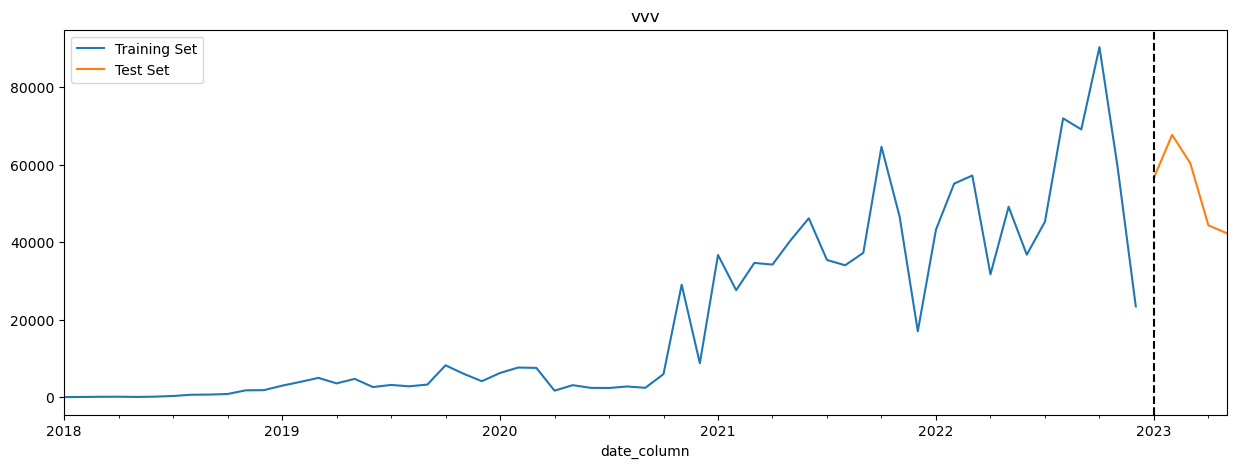

In [48]:
#Plot train/test data
def plot_train_test_data(df_train_func: pd.DataFrame, 
                         df_test_func: pd.DataFrame, 
                         split_date: datetime) -> None:
    """
    Generate plot illustrating train and test data wrt total sales at shop at each timestep.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :param split_date: Date on which training and testing data was split
    """
    #Aggragate data for plot
    df_train_func = df_train_func.groupby(by='date_column').agg({'num_signups':'sum'})
    df_test_func = df_test_func.groupby(by='date_column').agg({'num_signups':'sum'})
    
    print(' ')
    print(' ')
    print(f'Below the training and testing data is illustrated')
    
    #Create plot
    fig, ax = plt.subplots(figsize=(15, 5))
    df_train_func.plot(ax=ax, label='Training Set', title='vvv')
    df_test_func.plot(ax=ax, label='Test Set')
    ax.axvline(split_date, color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()
    
#Plot train/test
plot_train_test_data(df_train, df_test, split_date)

In [49]:
#reset index of dfs
def reset_indx(df_train_func: pd.DataFrame, df_test_func: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Reset index of dataframes.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :return: tuple[pd.DataFrame, pd.DataFrame], one for training data, one for testing
    """
    df_train_func = df_train_func.reset_index()
    df_test_func = df_test_func.reset_index()
    
    return df_train_func, df_test_func

#Reset index
df_train, df_test = reset_indx(df_train, df_test)

In [50]:
#Drop unwanted columns
def drop_columns(df_train_func: pd.DataFrame, 
                 df_test_func: pd.DataFrame, 
                 columns_to_drop: list) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Remove the columns we do not want to include as features to the prediction model.
    :param df_train_func: pd.DataFrame containing training data
    :param df_test_func: pd.DataFrame containing testing data
    :param columns_to_drop: List of column names to drop
    """
    df_train_func = df_train_func.drop(columns_to_drop, axis=1)
    df_test_func = df_test_func.drop(columns_to_drop, axis=1)
    
    return df_train_func, df_test_func

#drop unwanted columns
columns_to_drop = ['date_column']
df_train, df_test = drop_columns(df_train, df_test, columns_to_drop)

In [51]:
df_train

,num_signups,num_signups_one_back,num_signups_twelve_back,year,month,province_eastern cape,province_free state,province_gauteng,province_kwazulu natal,province_limpopo,province_mpumalanga,province_north west,province_northern cape,province_western cape
0,0.0,0.0,0.0,2018,1,1,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,2018,2,1,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,2018,3,1,0,0,0,0,0,0,0,0
3,2.0,0.0,0.0,2018,4,1,0,0,0,0,0,0,0,0
4,0.0,2.0,0.0,2018,5,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,9718.0,6800.0,6643.0,2022,8,0,0,0,0,0,0,0,0,1
536,8487.0,9718.0,8453.0,2022,9,0,0,0,0,0,0,0,0,1
537,10299.0,8487.0,7424.0,2022,10,0,0,0,0,0,0,0,0,1
538,8297.0,10299.0,8584.0,2022,11,0,0,0,0,0,0,0,0,1


### Create XGboost model

In [52]:
#Capture Features and target names
def extract_feats_target(df_train_func: pd.DataFrame, target: str) -> tuple[list, str]:
    """
    Capture features and target names.
    :param df_train_func: pd.DataFrame containing training data
    :return: tuple[list, str], list of feature names, string of target name
    """
    FEATURES = list(df_train_func)
    FEATURES.remove(target)
    TARGET = target
    
    return FEATURES, TARGET

#Identify features and target names
FEATURES, TARGET = extract_feats_target(df_train, 'num_signups') 

In [53]:
#Create Xs & Ys
def create_x_y(train: pd.DataFrame, 
               test: pd.DataFrame, 
               feats: list, 
               targ: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Seperate train and test dataframes into separate dataframes according to the feature and target split.
    :param train: pd.DataFrame containing the training data
    :param test: pd.DataFrame containing the testing data
    :param feats: List of the feature names
    :param targ: String of the target name
    :return: X_train, y_train, X_test, y_test
    """
    X_train = train[feats]
    y_train = train[targ]

    X_test = test[feats]
    y_test = test[targ]
    
    return X_train, y_train, X_test, y_test


#Split data
X_train, y_train, X_test, y_test = create_x_y(df_train, df_test, FEATURES, TARGET)

In [37]:
def fit_model_with_grid_search(
    model:xgb.XGBRegressor, 
    param_grid: dict,
    n_splits: int,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    verbose: int = 1) -> GridSearchCV:
    """
    Fit the model on the time series data with grid search for hyperparameter tuning.
    """
    time_series_split = TimeSeriesSplit(n_splits=n_splits)
    
    grid_search = GridSearchCV(model, param_grid, cv=time_series_split,
                               scoring='neg_mean_squared_error',
                               return_train_score=True,
                               verbose=verbose)
    
    grid_search.fit(X_train, y_train)
    
    print('Best parameters found: ', grid_search.best_params_)
    
    final_model = grid_search.best_estimator_
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    final_model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)
    
    return final_model

param_grid = {
    'max_depth': [3, 5], 
    'learning_rate': [0.01, 0.1], 
    'n_estimators': [100, 500, 1000], 
    'subsample': [0.7, 1.0], 
    'colsample_bytree': [0.7, 1.0], 
    'gamma': [0, 0.25, 0.5, 1.0]
}

model = fit_model_with_grid_search(model=xgb.XGBRegressor(),
                                   param_grid=param_grid, 
                                   n_splits=5, 
                                   X_train=X_train, 
                                   y_train=y_train, 
                                   X_test=X_test, 
                                   y_test=y_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
[0]	validation_0-rmse:4517.21030	validation_1-rmse:7382.87718
[1]	validation_0-rmse:4146.61301	validation_1-rmse:6778.01110
[2]	validation_0-rmse:3831.50602	validation_1-rmse:6260.39436
[3]	validation_0-rmse:3547.14920	validation_1-rmse:5693.65062
[4]	validation_0-rmse:3273.67038	validation_1-rmse:5236.12591
[5]	validation_0-rmse:3037.02779	validation_1-rmse:4852.22794
[6]	validation_0-rmse:2818.53164	validation_1-rmse:4494.78715
[7]	validation_0-rmse:2628.68014	validation_1-rmse:4137.02520
[8]	validation_0-rmse:2469.16590	validation_1-rmse:3884.12251
[9]	validation_0-rmse:2326.83136	validation_1-rmse:3688.85729
[10]	validation_0-rmse:2206.12738	validation_1-rmse:3473.47199
[11]	validation_0-rmse:2096.32932	validation_1-rmse:3287.43002
[12]	validation_0-rmse:1991.99722	validation_1-rmse:

 
 
Below the feature importance wrt predictions is illustrated


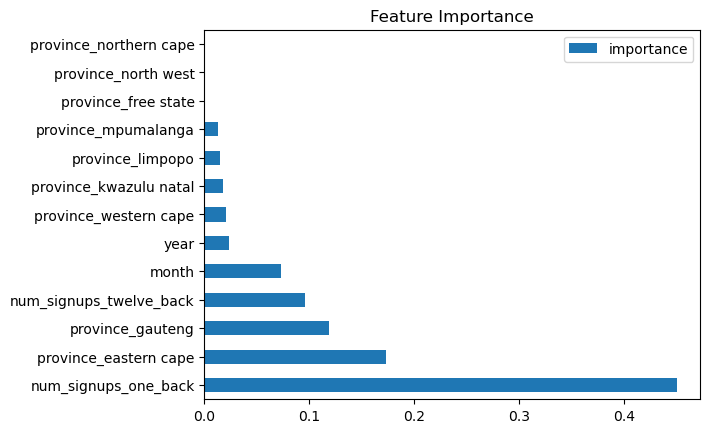

In [54]:
#feature importance
def plot_feature_importance(model: xgb.XGBRegressor) -> None:
    """
    Create a plot of the shop specific feature importance for the trained model.
    :param model: The received model to be trained
    :param shop: Integer indicating the shop
    :return: None
    """
    print(' ')
    print(' ')
    print(f'Below the feature importance wrt predictions is illustrated')
    fi = pd.DataFrame(data=model.feature_importances_,
                 index=model.feature_names_in_,
                 columns=['importance'])
    fi.sort_values('importance', ascending=False)[:20].plot(kind='barh', title='Feature Importance')
    plt.show()
    
#Plot feature importance
plot_feature_importance(model)

In [55]:
df

,num_signups,num_signups_one_back,num_signups_twelve_back,year,month,province_eastern cape,province_free state,province_gauteng,province_kwazulu natal,province_limpopo,province_mpumalanga,province_north west,province_northern cape,province_western cape
date_column,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,2018,1,1,0,0,0,0,0,0,0,0
2018-02-01,1.0,0.0,0.0,2018,2,1,0,0,0,0,0,0,0,0
2018-03-01,0.0,1.0,0.0,2018,3,1,0,0,0,0,0,0,0,0
2018-04-01,2.0,0.0,0.0,2018,4,1,0,0,0,0,0,0,0,0
2018-05-01,0.0,2.0,0.0,2018,5,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,7935.0,3881.0,8640.0,2023,1,0,0,0,0,0,0,0,0,1
2023-02-01,9423.0,7935.0,7137.0,2023,2,0,0,0,0,0,0,0,0,1
2023-03-01,10783.0,9423.0,6316.0,2023,3,0,0,0,0,0,0,0,0,1


In [61]:
#prep predictions
def prepare_preds(model: xgb.XGBRegressor, 
                    X_test_func: pd.DataFrame, 
                    df_test_func: pd.DataFrame,
                    columns_to_keep: list) -> pd.DataFrame:
    """
    Prepare dataframe containing predictions for ploting and saving to file
    :param model: The received model to be trained
    :param X_test_func: pd.DataFrame containing testing feature data
    :param test_func: pd.DataFrame containing all testing data (features & target)
    :param columns_to_keep: List indicating columns of interest
    :return: pd.DataFrame containing predictions and data of interest
    """
    #save predictions to df
    df_test_func['prediction'] = model.predict(X_test_func)
    #round predictions to nearest integer
    df_test_func['prediction'] = df_test_func['prediction'].round()
    df_test_func['day'] = 1 #day assigned just for plotting
    df_test_func['date'] = pd.to_datetime(df_test_func[['year', 'month', 'day']])
    df_preds = df_test_func.copy()
    #Set date as index
    df_preds = df_preds.set_index('date')
    # get the columns related to 'province'
    province_cols = [col for col in df_preds.columns if 'province' in col]
    # identify which 'province' column is 1 for each row
    df_preds['province'] = df_preds[province_cols].idxmax(axis=1)
    # remove the 'province_' prefix from the 'province' column
    df_preds['province'] = df_preds['province'].str.replace('province_', '')
    # drop unwanted columns
    df_preds = df_preds[columns_to_keep]
    
    return df_preds

#Prepare predictions for plotting
columns_to_keep = ['num_signups', 'province', 'prediction']
df_preds = prepare_preds(model, X_test, df_test, columns_to_keep) 


In [62]:
df_preds

,num_signups,province,prediction
date,,,
2023-01-01,4904.0,eastern cape,5102.0
2023-02-01,6094.0,eastern cape,4484.0
2023-03-01,5817.0,eastern cape,3906.0
2023-04-01,3610.0,eastern cape,4701.0
2023-05-01,4058.0,eastern cape,3562.0
2023-01-01,4304.0,free state,3928.0
2023-02-01,5026.0,free state,4701.0
2023-03-01,3041.0,free state,3981.0
2023-04-01,2566.0,free state,3958.0


 
 
Below are plots illustrating predicted vs actual signups.


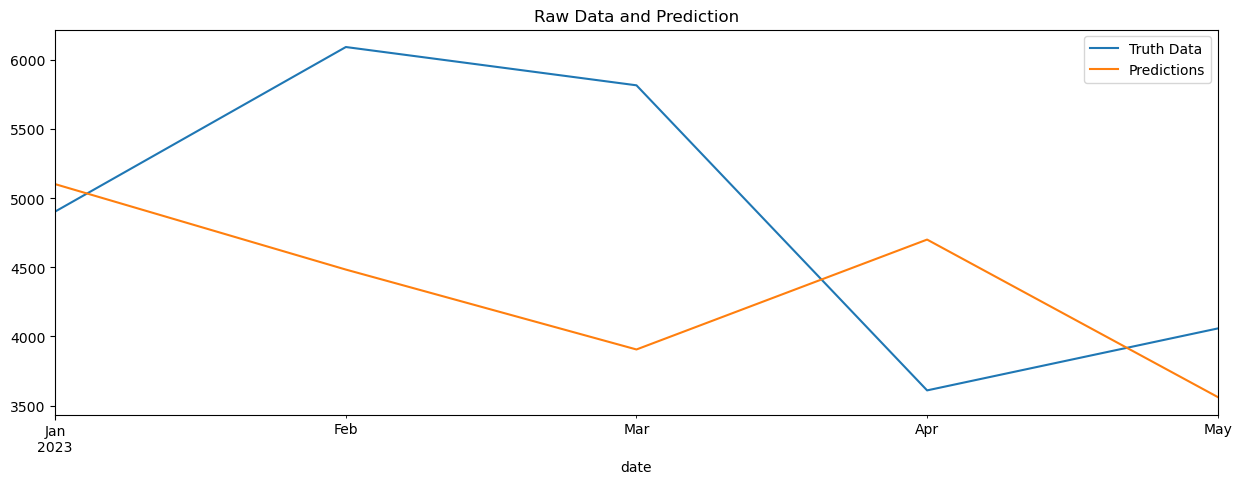

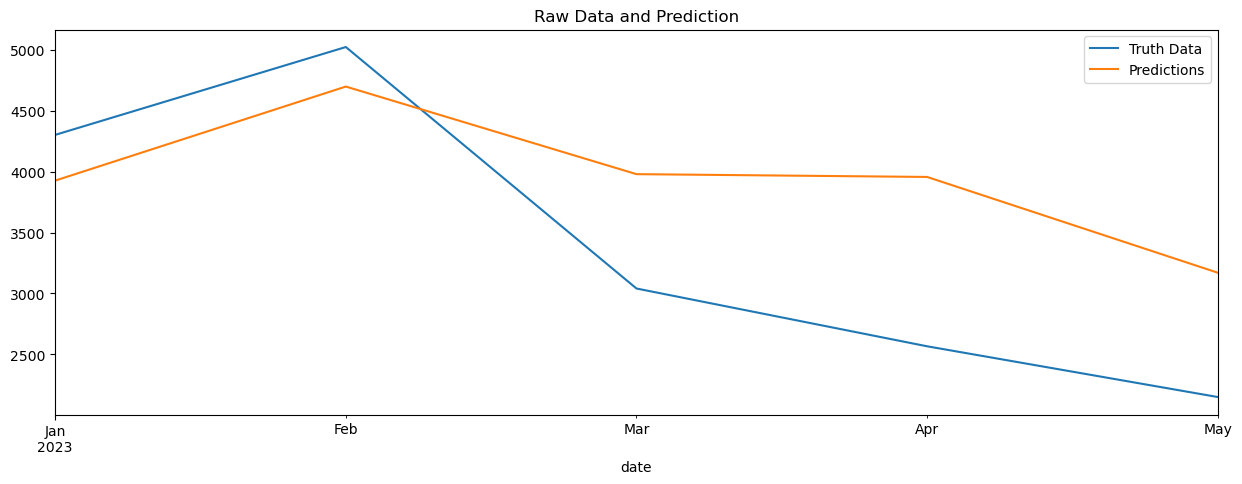

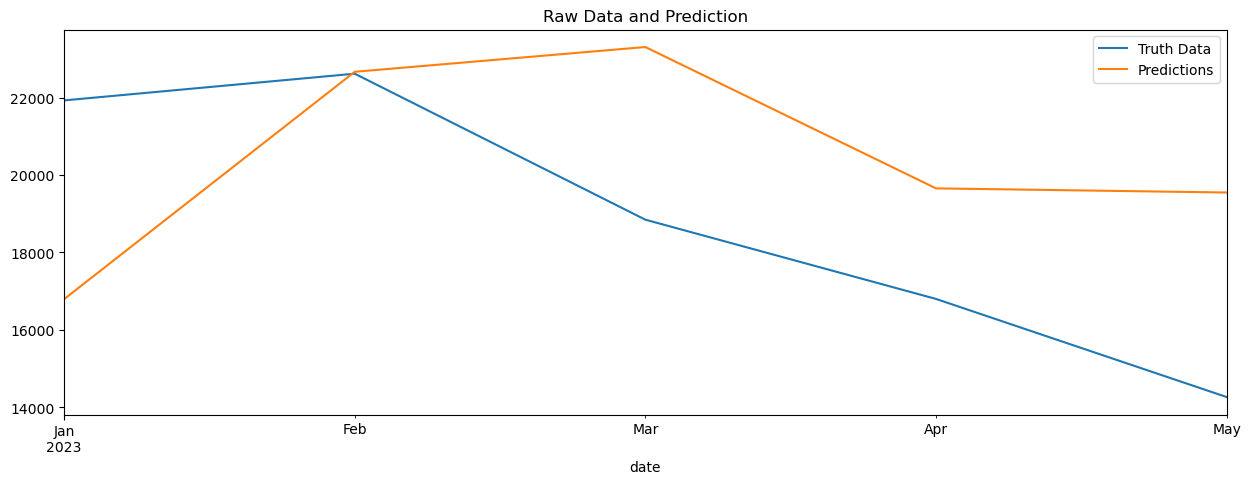

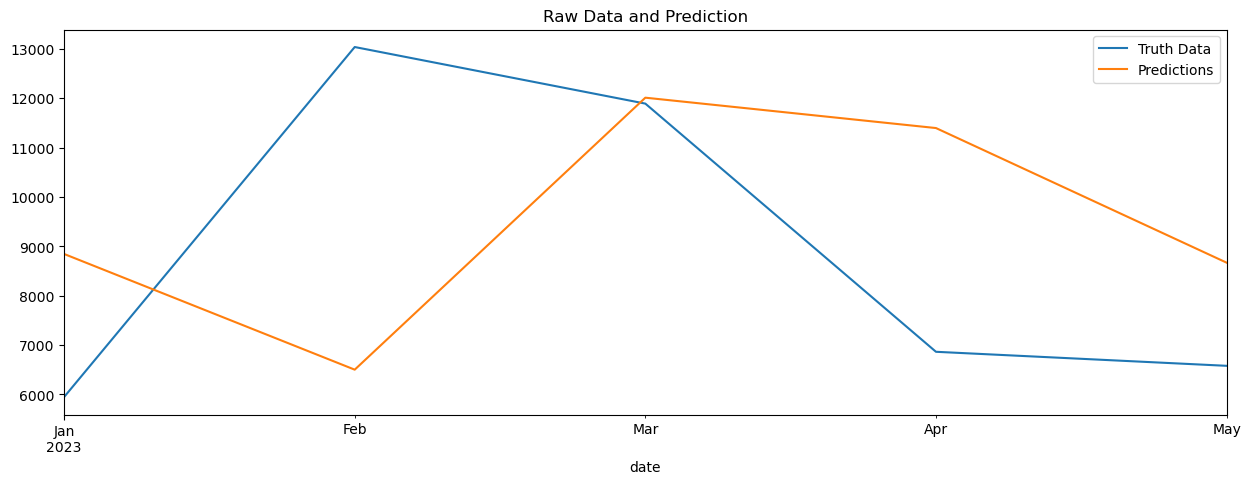

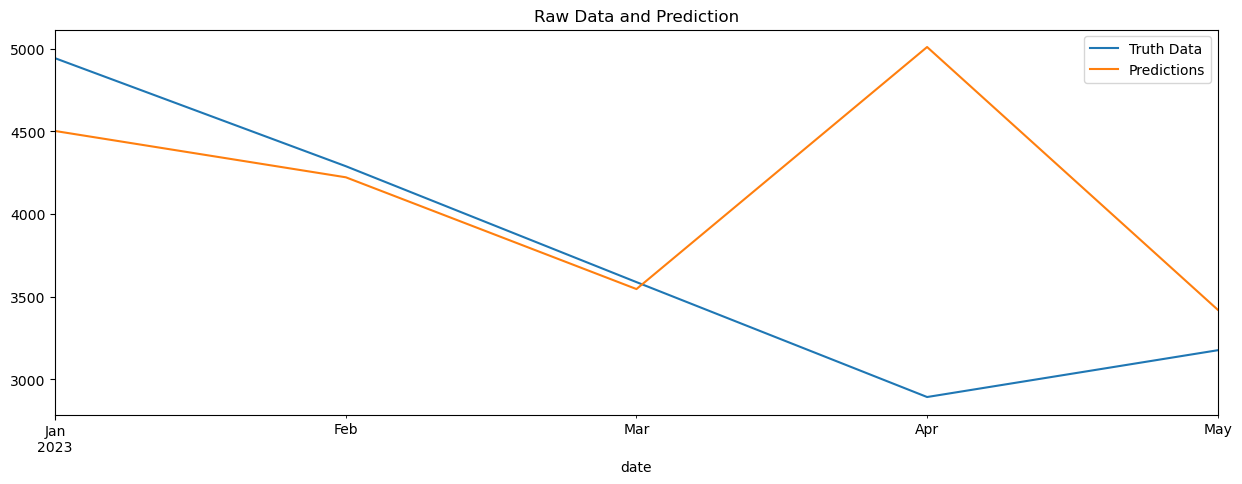

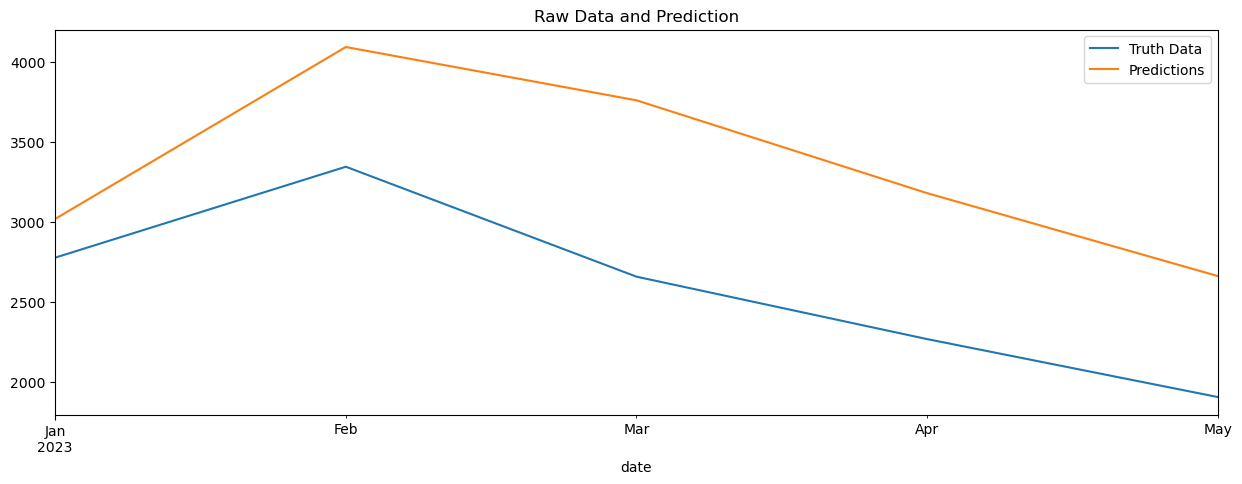

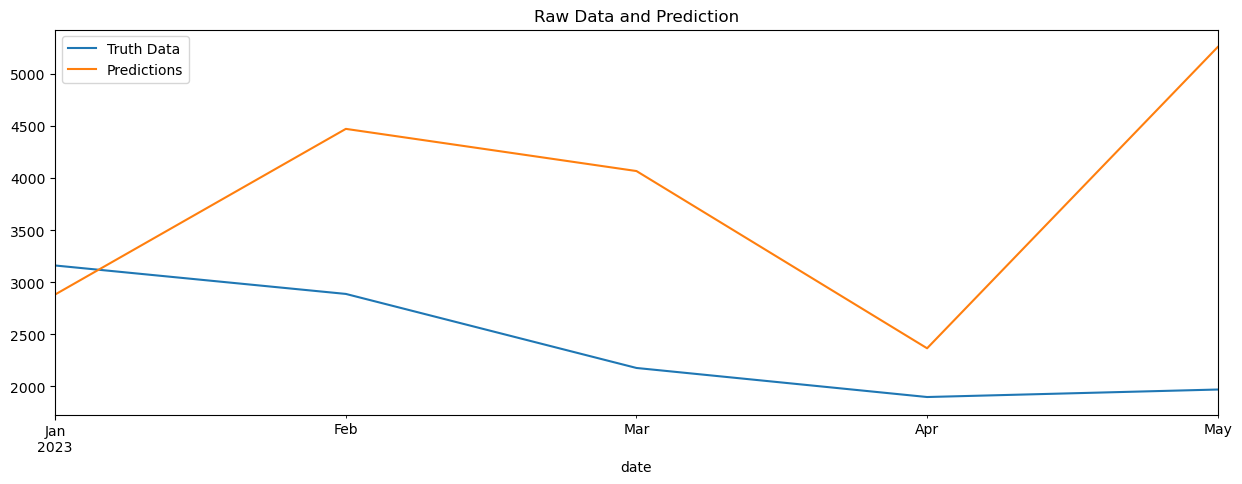

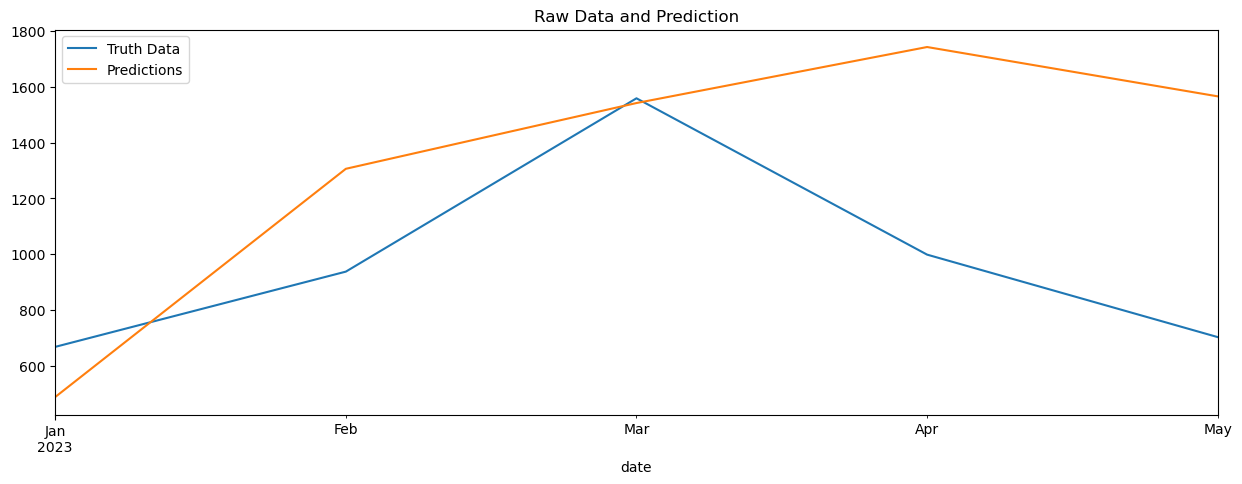

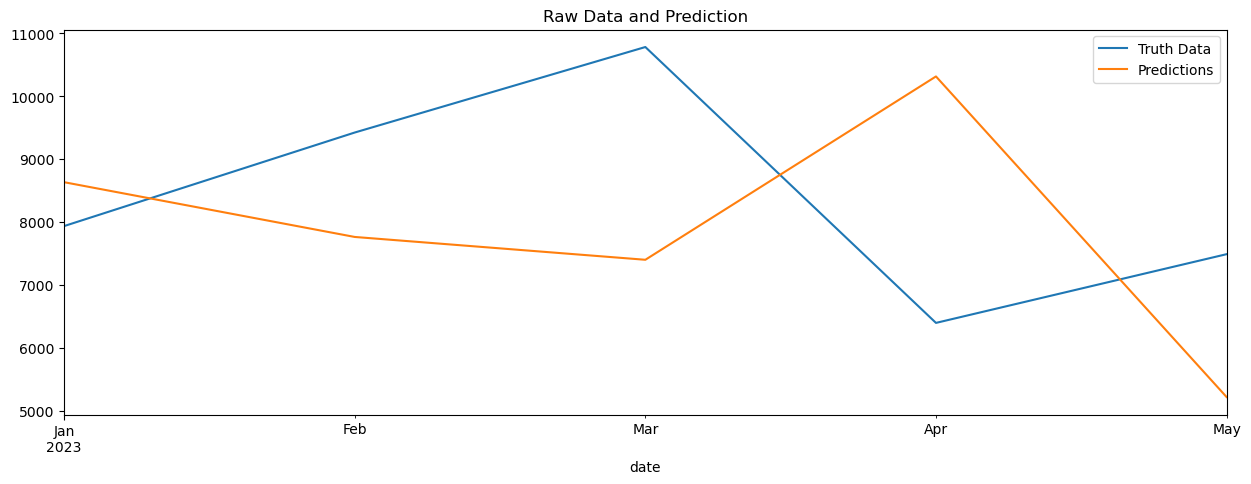

In [64]:
#plot preds
def plot_predictions(df_preds_func: pd.DataFrame) -> None:
    """
    Create plots illustrating predicted vs actual sales for the first 10 products at each shop.
    :param df_preds_func: pd.DataFrame containing predictions and additional data for saving
    :param shop: Integer indicating shop
    :return: None    """
    provinces = df_preds_func['province'].unique()
    print(' ')
    print(' ')
    print(f'Below are plots illustrating predicted vs actual signups.')
    for province in provinces:
        df_plot = df_preds_func[df_preds_func['province']==province]
        ax = df_plot[['num_signups']].plot(figsize=(15, 5))
        df_plot['prediction'].plot(ax=ax)
        plt.legend(['Truth Data', 'Predictions'])
        ax.set_title(f'Raw Data and Prediction')
        plt.show()
    
#Plot selected predictions
plot_predictions(df_preds)

In [ ]:
# Assume X_test is your test set and that num_signups is the last column
X_test = X_test.copy()  # to avoid modifying the original DataFrame
predictions = []

for i in range(len(X_test)):
    # Make a prediction for the current row
    prediction = model.predict(X_test.iloc[i, :].values.reshape(1, -1))[0]
    predictions.append(prediction)

    # If this isn't the last row, set the num_signups for the next row
    # to the prediction for the current row
    if i < len(X_test) - 1:
        X_test.iloc[i+1, -1] = prediction
